# 3) Pre-Processing
## Checklist (non-exhaustive)
-   Creation train/test set
-   Elimination of NaN : dropna(), imputation, empty col
-   Encoding of categorical variables
-   Delete outliers with negative impact on the model
-   Feature Selection
-   Feature Engineering (PCA after creating a lot of variables)
-   Feature Scaling

## Objectifs
1. Formating Data 
- Train/Test/Validation set
- Encoding
- Remove NaN

2. Improve model performance
- Feature Selection
- Feature Engineering
- Feature Scaling 
- Delete Outliers

In [1]:
# Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
pd.set_option('display.max_column', 150)

In [2]:
train_data = pd.read_csv('/Users/theob/Desktop/DSBA ESSEC CENTRAL/Cours/Courses/Foundation of Machine Learning (FLM)/Homework/Ass2/Git-Code/Credit-Score-Classification/data/train_set.csv', index_col=0)
train_data.name = 'train_data'
test_data = pd.read_csv('/Users/theob/Desktop/DSBA ESSEC CENTRAL/Cours/Courses/Foundation of Machine Learning (FLM)/Homework/Ass2/Git-Code/Credit-Score-Classification/data/test_set.csv', index_col=0)
test_data.name = 'test_data'

In [3]:
trainset, testset = train_test_split(train_data, test_size=0.2, random_state=0)

In [4]:
def one_hot_encoding_col(df, col):
    df = pd.get_dummies(df, columns=col)
    df = df.replace({False: 0, True: 1})
    return df

In [5]:
def one_hot_encoding_loan_type(df):

    loan_types = df['Type_of_Loan'].str.split(',', expand=True)
    encoded_loans = pd.get_dummies(loan_types, prefix='', prefix_sep='').groupby(level=0, axis=1).max()
    df = pd.concat([df, encoded_loans], axis=1)
    df = df.replace({False: 0, True: 1})
    return df


In [6]:
def preprocessing(df, data_type):
    df = one_hot_encoding_col(df, ['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour'])
    df = one_hot_encoding_loan_type(df)
    df = df.drop(['Customer_ID', 'Name', 'SSN', 'Type_of_Loan'], axis=1)
    

    if data_type == 'train':
        X = df.drop(['Credit_Score'], axis=1)
        y = df['Credit_Score']
   
   
        categories = [['Poor', 'Standard', 'Good']]
        encoder = OrdinalEncoder(categories=categories)
        y = encoder.fit_transform(y.values.reshape(-1, 1))
        y = y.ravel()
        return X, y
    else:
        X = df
        return X
   


In [7]:
X_train, y_train = preprocessing(trainset, 'train')
X_test, y_test = preprocessing(trainset, 'train')
# 0 = Poor
# 1 = Standard
# 2 = Good

# Model Selection


In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA

In [9]:
# Baseline model -> OVERFITTING
model_test1 = DecisionTreeClassifier(random_state=0) 

# Better but OVERFITTING
model_test2 = RandomForestClassifier(random_state=0)

# Here we select thanks to an ANOVA Test only the best k features in term of importance in our model -> GOOD
model_test3 = make_pipeline(SelectKBest(f_classif, k=9), 
                      RandomForestClassifier(random_state=0) )

# Use Polynomial Feature to combine feature and but square them -> GOOD MODEL
model_test4 = make_pipeline(PolynomialFeatures(2),
                            SelectKBest(f_classif,k=10),
                            RandomForestClassifier(random_state=0))

# Use PCA as a feature selection algorithm -> BUT TOO MUCH OVERFITTING
model_test5 = make_pipeline(PolynomialFeatures(2),
                            PCA(n_components=5),
                            RandomForestClassifier(random_state=0))

# Evaluation


In [10]:
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve #Now if the model is under or over fitting

In [11]:
def evaluation(model):
    
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    
    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, scoring='f1_weighted',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


def plot_class_histograms(model,X_train,y_train, X_test, y_true, class_labels):
    """
    Plots histograms for each class showing the distribution of predicted probabilities.
    """
    model.fit(X_train, y_train)

    # Prédire les probabilités pour chaque classe
    y_pred_probs = model.predict_proba(X_test)

    num_classes = len(class_labels)
    fig, axes = plt.subplots(1, num_classes, figsize=(num_classes * 5, 5))

    for i in range(num_classes):
        axes[i].hist(y_pred_probs[:, i], bins=10, alpha=0.7)
        axes[i].set_title(f'Predicted Probabilities for Class {class_labels[i]}')
        axes[i].set_xlabel('Probability')
        axes[i].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

def plot_roc_curves(model,X_train,y_train, X_test, y_test, class_labels):
    """
    Plots ROC curves for each class (One-vs-Rest).
    """
    model.fit(X_train, y_train)

    # Prédire les probabilités pour chaque classe
    y_pred_probs = model.predict_proba(X_test)

    num_classes = len(class_labels)
    fig, ax = plt.subplots(figsize=(8, 6))

    for i in range(num_classes):
        # Create a binary array for current class
        y_true_binary = (y_test == i).astype(int)
        
        # Compute ROC curve and ROC area for each class
        fpr, tpr, _ = roc_curve(y_true_binary, y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)

        ax.plot(fpr, tpr, lw=2, label=f'Class {class_labels[i]} (area = {roc_auc:.2f})')

    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curves for Each Class')
    ax.legend(loc="lower right")

    plt.show()

# Example usage (assuming y_test is your true labels and y_pred_probs is your predicted probabilities):
class_labels = [0, 1, 2]  # Adjust based on your classes
# plot_class_histograms(y_test, y_pred_probs, class_labels)
# plot_roc_curves(y_test, y_pred_probs, class_labels)


In [13]:

#plot_roc_curves(model_test4,X_train,y_train, X_test, y_test, class_labels)
#plot_class_histograms(model_test4,X_train,y_train, X_test, y_test, class_labels)

In [14]:
# Remove low importance feature to avoid overfitting
# Conclusion : This idea doesn't cope the overfitting problem
#def improved_processing(X,y, col_list):
 #   X = X[col_list]
 #   return X, y
#X_train, y_train = improved_processing(X_train,y_train,col_list)
#X_test, y_test = improved_processing(X_test,y_test,col_list)

# Modeling

In [19]:
preprocessor = make_pipeline(PolynomialFeatures(2, include_bias=False),
                             SelectKBest(f_classif, k=7))

In [20]:
RandomForest = make_pipeline(preprocessor, RandomForestClassifier(random_state=0))
AdaBoost = make_pipeline(preprocessor, AdaBoostClassifier(random_state=0))
KNN = make_pipeline(preprocessor, StandardScaler(), KNeighborsClassifier())

In [21]:
list_of_model = [RandomForest, AdaBoost, KNN]

/Users/theob/Library/Python/3.9/lib/python/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 457  893  894  895  896  897  898  899  900  901  902  903  904  905
  906  930  931  932  933  934  935  936  937  938  939  940  941  942
  966  967  968  969  970  971  972  973  974  975  976  977 1001 1002
 1003 1004 1005 1006 1007 1008 1009 1010 1011 1035 1036 1037 1038 1039
 1040 1041 1042 1043 1044 1068 1069 1070 1071 1072 1073 1074 1075 1076
 1100 1101 1102 1103 1104 1105 1106 1107 1131 1132 1133 1134 1135 1136
 1137 1161 1162 1163 1164 1165 1166 1190 1191 1192 1193 1194 1218 1219
 1220 1221 1245 1246 1247 1271 1272 1296 1343 1344 1346 1354 1365 1368
 1406 1407 1425 1460 1461 1462 1463 1464 1476 1477 1478 1479 1491 1492
 1493 1505 1506 1518 1541 1542 1543 1544 1545 1546 1547 1548 1549] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/theob/Library/Python/3.9/lib/python/site-packages/sklear

[[12870  3373     0]
 [ 5654 24079     0]
 [  238  1427  8359]]
              precision    recall  f1-score   support

         0.0       0.69      0.79      0.74     16243
         1.0       0.83      0.81      0.82     29733
         2.0       1.00      0.83      0.91     10024

    accuracy                           0.81     56000
   macro avg       0.84      0.81      0.82     56000
weighted avg       0.82      0.81      0.81     56000



/Users/theob/Library/Python/3.9/lib/python/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 457  893  894  895  896  897  898  899  900  901  902  903  904  905
  906  930  931  932  933  934  935  936  937  938  939  940  941  942
  966  967  968  969  970  971  972  973  974  975  976  977 1001 1002
 1003 1004 1005 1006 1007 1008 1009 1010 1011 1035 1036 1037 1038 1039
 1040 1041 1042 1043 1044 1068 1069 1070 1071 1072 1073 1074 1075 1076
 1100 1101 1102 1103 1104 1105 1106 1107 1131 1132 1133 1134 1135 1136
 1137 1161 1162 1163 1164 1165 1166 1190 1191 1192 1193 1194 1218 1219
 1220 1221 1245 1246 1247 1271 1272 1296 1343 1344 1346 1354 1365 1368
 1406 1407 1425 1460 1461 1462 1463 1464 1476 1477 1478 1479 1491 1492
 1493 1505 1506 1518 1541 1542 1543 1544 1545 1546 1547 1548 1549] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/theob/Library/Python/3.9/lib/python/site-packages/sklear

[[11224  2318  2701]
 [ 7243 16550  5940]
 [  379  1367  8278]]
              precision    recall  f1-score   support

         0.0       0.60      0.69      0.64     16243
         1.0       0.82      0.56      0.66     29733
         2.0       0.49      0.83      0.61     10024

    accuracy                           0.64     56000
   macro avg       0.63      0.69      0.64     56000
weighted avg       0.69      0.64      0.65     56000



/Users/theob/Library/Python/3.9/lib/python/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 457  893  894  895  896  897  898  899  900  901  902  903  904  905
  906  930  931  932  933  934  935  936  937  938  939  940  941  942
  966  967  968  969  970  971  972  973  974  975  976  977 1001 1002
 1003 1004 1005 1006 1007 1008 1009 1010 1011 1035 1036 1037 1038 1039
 1040 1041 1042 1043 1044 1068 1069 1070 1071 1072 1073 1074 1075 1076
 1100 1101 1102 1103 1104 1105 1106 1107 1131 1132 1133 1134 1135 1136
 1137 1161 1162 1163 1164 1165 1166 1190 1191 1192 1193 1194 1218 1219
 1220 1221 1245 1246 1247 1271 1272 1296 1343 1344 1346 1354 1365 1368
 1406 1407 1425 1460 1461 1462 1463 1464 1476 1477 1478 1479 1491 1492
 1493 1505 1506 1518 1541 1542 1543 1544 1545 1546 1547 1548 1549] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/theob/Library/Python/3.9/lib/python/site-packages/sklear

[[ 9286  6258   699]
 [ 5177 22592  1964]
 [  857  3222  5945]]
              precision    recall  f1-score   support

         0.0       0.61      0.57      0.59     16243
         1.0       0.70      0.76      0.73     29733
         2.0       0.69      0.59      0.64     10024

    accuracy                           0.68     56000
   macro avg       0.67      0.64      0.65     56000
weighted avg       0.67      0.68      0.67     56000



/Users/theob/Library/Python/3.9/lib/python/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 457  893  894  895  896  897  898  899  900  901  902  903  904  905
  906  930  931  932  933  934  935  936  937  938  939  940  941  942
  966  967  968  969  970  971  972  973  974  975  976  977 1001 1002
 1003 1004 1005 1006 1007 1008 1009 1010 1011 1035 1036 1037 1038 1039
 1040 1041 1042 1043 1044 1068 1069 1070 1071 1072 1073 1074 1075 1076
 1100 1101 1102 1103 1104 1105 1106 1107 1131 1132 1133 1134 1135 1136
 1137 1161 1162 1163 1164 1165 1166 1190 1191 1192 1193 1194 1218 1219
 1220 1221 1245 1246 1247 1271 1272 1296 1343 1344 1346 1354 1365 1368
 1406 1407 1425 1460 1461 1462 1463 1464 1476 1477 1478 1479 1491 1492
 1493 1505 1506 1518 1541 1542 1543 1544 1545 1546 1547 1548 1549] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/theob/Library/Python/3.9/lib/python/site-packages/sklear

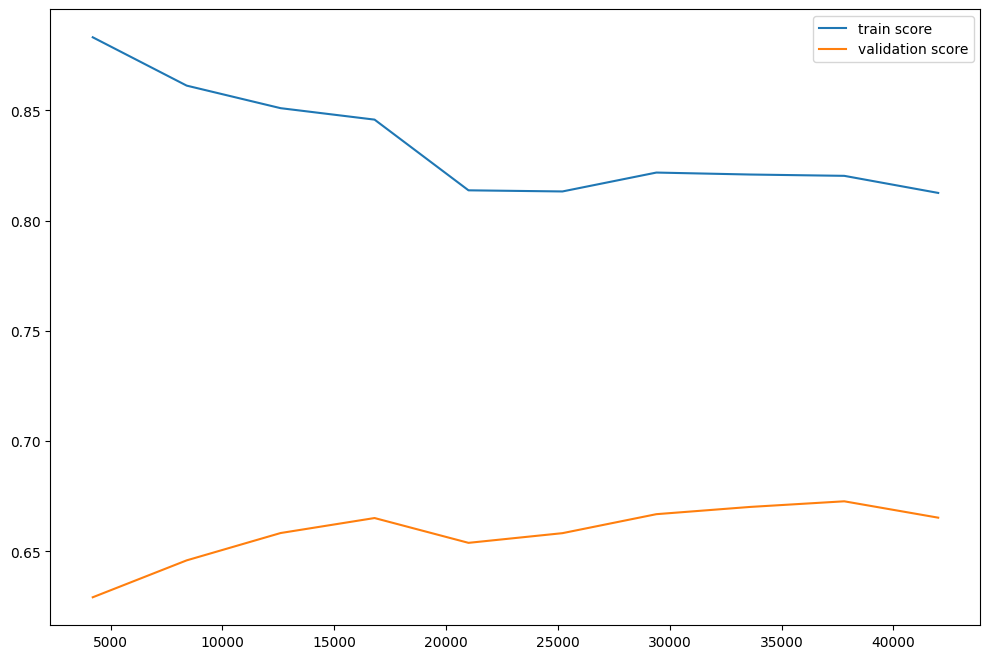

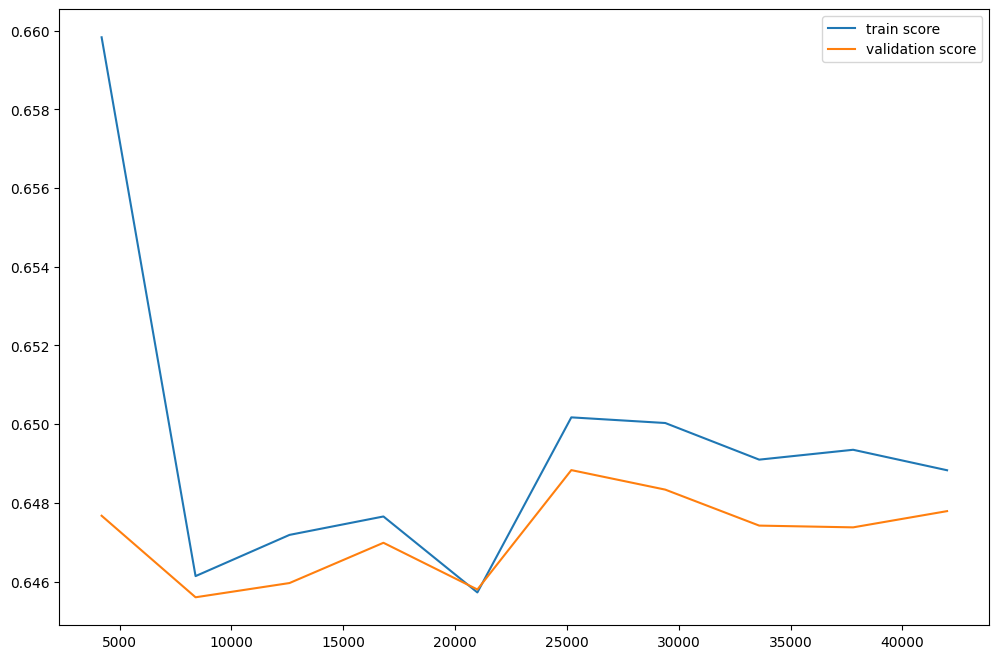

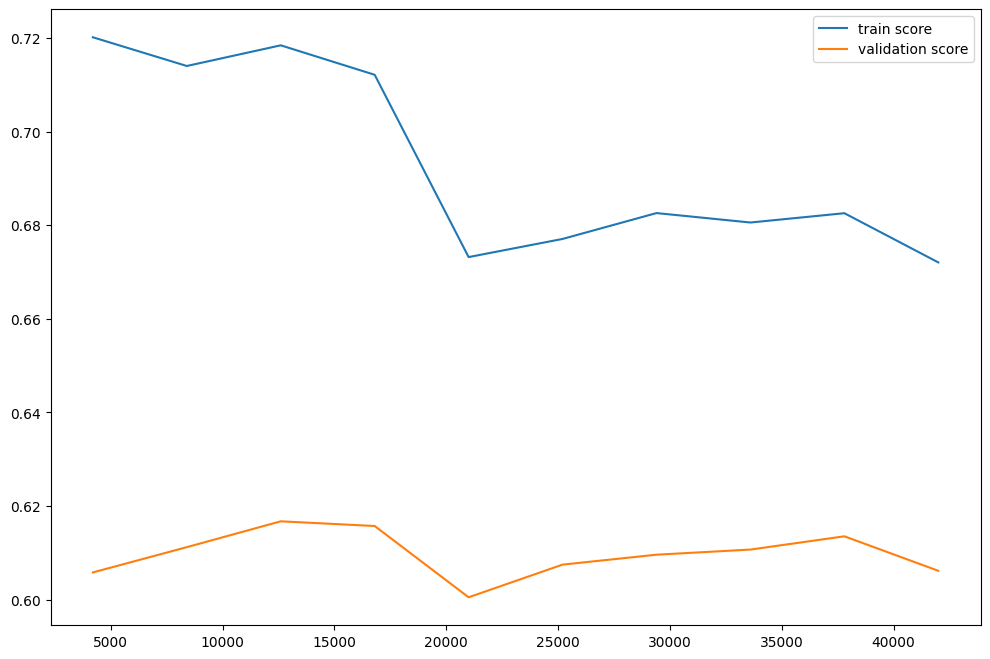

In [22]:
for model in list_of_model:
    evaluation(model)

# Optimisation

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn import set_config
set_config(display="text") # or text or diagram
RandomForest

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('polynomialfeatures',
                                  PolynomialFeatures(include_bias=False)),
                                 ('selectkbest', SelectKBest(k=7))])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=0))])

In [40]:
hyper_params = {'randomforestclassifier__n_estimators':[200, 500, 1000, 2000],
                 'randomforestclassifier__max_depth': [10, 20, 30, 60],
                 'randomforestclassifier__min_samples_split' : [2, 5, 10]}

In [41]:
grid = GridSearchCV(RandomForest, hyper_params, scoring='f1_weighted', cv=3)
grid.fit(X_train, y_train)
print(grid.best_params_)

/Users/theob/Library/Python/3.9/lib/python/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 457  893  894  895  896  897  898  899  900  901  902  903  904  905
  906  930  931  932  933  934  935  936  937  938  939  940  941  942
  966  967  968  969  970  971  972  973  974  975  976  977 1001 1002
 1003 1004 1005 1006 1007 1008 1009 1010 1011 1035 1036 1037 1038 1039
 1040 1041 1042 1043 1044 1068 1069 1070 1071 1072 1073 1074 1075 1076
 1100 1101 1102 1103 1104 1105 1106 1107 1131 1132 1133 1134 1135 1136
 1137 1161 1162 1163 1164 1165 1166 1190 1191 1192 1193 1194 1218 1219
 1220 1221 1245 1246 1247 1271 1272 1296 1343 1344 1346 1354 1365 1368
 1406 1407 1425 1460 1461 1462 1463 1464 1476 1477 1478 1479 1491 1492
 1493 1505 1506 1518 1541 1542 1543 1544 1545 1546 1547 1548 1549] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/theob/Library/Python/3.9/lib/python/site-packages/sklear

{'randomforestclassifier__max_depth': 60, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 2000}


In [ ]:
best_hyper_params=
{'randomforestclassifier__max_depth': 60, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 2000}

#72min entrainement ...

In [42]:
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.69      0.79      0.74     16243
         1.0       0.83      0.81      0.82     29733
         2.0       1.00      0.83      0.91     10024

    accuracy                           0.81     56000
   macro avg       0.84      0.81      0.82     56000
weighted avg       0.82      0.81      0.81     56000



In [43]:
evaluation(grid.best_estimator_)

/Users/theob/Library/Python/3.9/lib/python/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 457  893  894  895  896  897  898  899  900  901  902  903  904  905
  906  930  931  932  933  934  935  936  937  938  939  940  941  942
  966  967  968  969  970  971  972  973  974  975  976  977 1001 1002
 1003 1004 1005 1006 1007 1008 1009 1010 1011 1035 1036 1037 1038 1039
 1040 1041 1042 1043 1044 1068 1069 1070 1071 1072 1073 1074 1075 1076
 1100 1101 1102 1103 1104 1105 1106 1107 1131 1132 1133 1134 1135 1136
 1137 1161 1162 1163 1164 1165 1166 1190 1191 1192 1193 1194 1218 1219
 1220 1221 1245 1246 1247 1271 1272 1296 1343 1344 1346 1354 1365 1368
 1406 1407 1425 1460 1461 1462 1463 1464 1476 1477 1478 1479 1491 1492
 1493 1505 1506 1518 1541 1542 1543 1544 1545 1546 1547 1548 1549] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/theob/Library/Python/3.9/lib/python/site-packages/sklear

[[12867  3376     0]
 [ 5651 24082     0]
 [  238  1427  8359]]
              precision    recall  f1-score   support

         0.0       0.69      0.79      0.74     16243
         1.0       0.83      0.81      0.82     29733
         2.0       1.00      0.83      0.91     10024

    accuracy                           0.81     56000
   macro avg       0.84      0.81      0.82     56000
weighted avg       0.82      0.81      0.81     56000



/Users/theob/Library/Python/3.9/lib/python/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 457  893  894  895  896  897  898  899  900  901  902  903  904  905
  906  930  931  932  933  934  935  936  937  938  939  940  941  942
  966  967  968  969  970  971  972  973  974  975  976  977 1001 1002
 1003 1004 1005 1006 1007 1008 1009 1010 1011 1035 1036 1037 1038 1039
 1040 1041 1042 1043 1044 1068 1069 1070 1071 1072 1073 1074 1075 1076
 1100 1101 1102 1103 1104 1105 1106 1107 1131 1132 1133 1134 1135 1136
 1137 1161 1162 1163 1164 1165 1166 1190 1191 1192 1193 1194 1218 1219
 1220 1221 1245 1246 1247 1271 1272 1296 1343 1344 1346 1354 1365 1368
 1406 1407 1425 1460 1461 1462 1463 1464 1476 1477 1478 1479 1491 1492
 1493 1505 1506 1518 1541 1542 1543 1544 1545 1546 1547 1548 1549] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/theob/Library/Python/3.9/lib/python/site-packages/sklear

KeyboardInterrupt: 